### IMPORTS

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
%pip install numpy matplotlib numba

In [3]:
!pip install --upgrade numba

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time
from numba import cuda, njit, prange, float32, int32
import cupy as cp
import math
import seaborn as sns
import pandas as pd
import numpy as np

### LOAD DATA

In [5]:
instances = [
    "berlin52.tsp",
    "brazil58.tsp",
    "d1655.tsp",
    "u2319.tsp",
    "fnl4461.tsp",
]

In [6]:
def load_tsp(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]

    dimension = None
    edge_weight_type = None
    node_coord_start = None
    edge_weight_start = None

    for i, line in enumerate(lines):
        if line.startswith("DIMENSION"):
            dimension = int(line.split(":")[1].strip())
        elif line.startswith("EDGE_WEIGHT_TYPE"):
            edge_weight_type = line.split(":")[1].strip()
        elif line.startswith("NODE_COORD_SECTION"):
            node_coord_start = i + 1
            break
        elif line.startswith("EDGE_WEIGHT_SECTION"):
            edge_weight_start = i + 1
            break

    if dimension is None:
        raise ValueError("Invalid file format: DIMENSION not found.")

    dist_matrix = np.zeros((dimension, dimension), dtype=np.float32)

    if edge_weight_type == "EXPLICIT" and edge_weight_start is not None:
        row = 0
        count = dimension - 1
        line_idx = edge_weight_start
        while count > 0:
            parts = lines[line_idx].split()
            if len(parts) != count:
                raise ValueError("Unexpected number of distances on line.")
            for offset, val in enumerate(parts, start=1):
                d = float(val)
                dist_matrix[row, row+offset] = d
                dist_matrix[row+offset, row] = d
            row += 1
            count -= 1
            line_idx += 1

    elif node_coord_start is not None:
        coords = []
        for i in range(node_coord_start, node_coord_start + dimension):
            parts = lines[i].split()
            x, y = float(parts[1]), float(parts[2])
            coords.append((x, y))
        coords = np.array(coords, dtype=np.float32)


        for i in range(dimension):
            for j in range(i+1, dimension):
                dx = coords[i,0] - coords[j,0]
                dy = coords[i,1] - coords[j,1]
                d = math.sqrt(dx*dx + dy*dy)
                dist_matrix[i,j] = d
                dist_matrix[j,i] = d

    else:
        raise ValueError("Invalid file format: no EDGE_WEIGHT_SECTION or NODE_COORD_SECTION found.")

    return dist_matrix

In [9]:
import time

distance_matrices = {}
loading_times = {}

for instance in instances:
    name = instance.replace(".tsp", "")
    start_time = time.time()
    try:
        dist_matrix = load_tsp(instance)
        end_time = time.time()
        load_duration = end_time - start_time

        distance_matrices[name] = dist_matrix
        loading_times[name] = load_duration

        print(f"Loaded {name}: {dist_matrix.shape[0]} cities in {load_duration:.4f}s")
    except ValueError as e:
        end_time = time.time()
        load_duration = end_time - start_time
        loading_times[name] = load_duration

        print(f"Error loading {instance} after {load_duration:.4f}s: {e}")

Loaded berlin52: 52 cities in 0.0034s
Loaded brazil58: 58 cities in 0.0011s
Loaded d1655: 1655 cities in 1.8275s
Loaded u2319: 2319 cities in 3.5842s
Loaded fnl4461: 4461 cities in 13.2054s


In [10]:
import os

os.makedirs("distance_matrices", exist_ok=True)

for name, dist_matrix in distance_matrices.items():
    filename = f"distance_matrices/{name}.npy"
    np.save(filename, dist_matrix)
    print(f"Saved {name} to {filename}")

Saved berlin52 to distance_matrices/berlin52.npy
Saved brazil58 to distance_matrices/brazil58.npy
Saved d1655 to distance_matrices/d1655.npy
Saved u2319 to distance_matrices/u2319.npy
Saved fnl4461 to distance_matrices/fnl4461.npy


In [ ]:
sorted_instances = sorted(distance_matrices.keys(), key=lambda x: distance_matrices[x].shape[0])
sorted_num_cities = [distance_matrices[name].shape[0] for name in sorted_instances]
sorted_load_times = [loading_times[name] for name in sorted_instances]

plt.figure(figsize=(10,6))
plt.plot(sorted_num_cities, sorted_load_times, 'o-', color='blue')
plt.xlabel('Number of Cities')
plt.ylabel('Loading Time (seconds)')
plt.title('Loading Time vs. Number of Cities')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import files
# files.download("distance_matrices/berlin52.npy")
# files.download("distance_matrices/brazil58.npy")
# files.download("distance_matrices/d1655.npy")
# files.download("distance_matrices/u2319.npy")
# files.download("distance_matrices/fnl4461.npy")

### Nearest Neighbors Implementation

In [11]:
ALG_NAME = "NearestNeighbor"

def nearest_neighbor_tsp_matrix(dist_matrix):
    """
    CPU implementation of nearest neighbor TSP using the precomputed dist_matrix.
    Returns the path and total distance.
    """
    num_cities = dist_matrix.shape[0]
    visited = np.zeros(num_cities, dtype=np.bool_)
    path = []
    total_distance = 0.0

    current_city = 0
    start_city = current_city
    path.append(current_city)
    visited[current_city] = True

    for _ in range(num_cities - 1):
        distances = dist_matrix[current_city].copy()
        distances[visited] = np.inf
        nearest_city = np.argmin(distances)
        min_distance = distances[nearest_city]

        path.append(nearest_city)
        visited[nearest_city] = True
        total_distance += min_distance
        current_city = nearest_city

    total_distance += dist_matrix[current_city, start_city]
    path.append(start_city)

    return path, total_distance

@cuda.jit
def compute_distances_matrix(current_city, dist_matrix, visited, distances):
    idx = cuda.grid(1)
    if idx < dist_matrix.shape[0]:
        if not visited[idx]:
            distances[idx] = dist_matrix[current_city, idx]
        else:
            distances[idx] = math.inf

def get_optimal_gpu_config(func, size):
    device = cuda.get_current_device()
    block_size = device.MAX_THREADS_PER_BLOCK
    blocks = (size + block_size - 1) // block_size
    return blocks, block_size

def nearest_neighbor_tsp_gpu_matrix(dist_matrix):
    """
    GPU implementation of nearest neighbor TSP using the precomputed dist_matrix.
    """
    num_cities = dist_matrix.shape[0]
    d_dist_matrix = cp.asarray(dist_matrix)

    visited = cp.zeros(num_cities, dtype=cp.bool_)
    path = []
    total_distance = cp.float32(0.0)

    current_city = 0
    start_city = current_city
    path.append(int(current_city))
    visited[current_city] = True

    d_visited = visited
    d_distances = cp.zeros(num_cities, dtype=cp.float32)

    blocks, threads_per_block = get_optimal_gpu_config(compute_distances_matrix, num_cities)

    for _ in range(num_cities - 1):
        compute_distances_matrix[blocks, threads_per_block](current_city, d_dist_matrix, d_visited, d_distances)
        nearest_city = cp.argmin(d_distances)
        min_distance = d_distances[nearest_city]

        path.append(int(nearest_city))
        d_visited[nearest_city] = True
        total_distance += min_distance
        current_city = nearest_city

    total_distance += d_dist_matrix[current_city, start_city]
    path.append(int(start_city))

    return path, float(total_distance.get())

def run_experiment_cpu_matrix_details(dist_matrix, trials=3):
    times = []
    d = None
    for _ in range(trials):
        start_time = time.time()
        path, dist_val = nearest_neighbor_tsp_matrix(dist_matrix)
        end_time = time.time()
        times.append(end_time - start_time)
        d = dist_val
    return times, d

def run_experiment_gpu_matrix_details(dist_matrix, trials=3):
    times = []
    d = None
    for _ in range(trials):
        start_time = time.time()
        path, dist_val = nearest_neighbor_tsp_gpu_matrix(dist_matrix)
        end_time = time.time()
        times.append(end_time - start_time)
        d = dist_val
    return times, d

In [12]:
instance_names = list(distance_matrices.keys())

In [13]:
results = {}

for name in instance_names:
    dist_matrix = distance_matrices[name]
    num_cities = dist_matrix.shape[0]
    print(f"\nRunning {ALG_NAME} for {name} ({num_cities} cities)...")

    cpu_times, cpu_dist = run_experiment_cpu_matrix_details(dist_matrix, trials=3)
    gpu_times, gpu_dist = run_experiment_gpu_matrix_details(dist_matrix, trials=3)

    cpu_avg_time = np.mean(cpu_times)
    gpu_avg_time = np.mean(gpu_times)

    results[name] = {
        'cpu_times_per_trial': cpu_times,
        'gpu_times_per_trial': gpu_times,
        'cpu_avg_time': cpu_avg_time,
        'gpu_avg_time': gpu_avg_time,
        'cpu_distance': cpu_dist,
        'gpu_distance': gpu_dist,
        'num_cities': num_cities
    }

    print(f"CPU Avg Time: {cpu_avg_time:.4f}s | GPU Avg Time: {gpu_avg_time:.4f}s")
    print(f"CPU Distance: {cpu_dist:.2f} | GPU Distance: {gpu_dist:.2f}")


rows = []
for name, data in results.items():
    rows.append({
        'Algorithm': ALG_NAME,
        'Instance': name,
        'NumCities': data['num_cities'],
        'CPU_AvgTime': data['cpu_avg_time'],
        'GPU_AvgTime': data['gpu_avg_time'],
        'CPU_TimeTrials': data['cpu_times_per_trial'],
        'GPU_TimeTrials': data['gpu_times_per_trial'],
        'CPU_Distance': data['cpu_distance'],
        'GPU_Distance': data['gpu_distance']
    })

nn_df = pd.DataFrame(rows)
main_df = nn_df.copy()
main_df


Running NearestNeighbor for berlin52 (52 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU Avg Time: 0.0008s | GPU Avg Time: 1.0247s
CPU Distance: 8980.92 | GPU Distance: 8980.92

Running NearestNeighbor for brazil58 (58 cities)...
CPU Avg Time: 0.0006s | GPU Avg Time: 0.0714s
CPU Distance: 30774.00 | GPU Distance: 30774.00

Running NearestNeighbor for d1655 (1655 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU Avg Time: 0.0180s | GPU Avg Time: 2.8146s
CPU Distance: 278783.31 | GPU Distance: 278783.47

Running NearestNeighbor for fnl4461 (4461 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CPU Avg Time: 0.0802s | GPU Avg Time: 5.4287s
CPU Distance: 227156.61 | GPU Distance: 227157.58


,Algorithm,Instance,NumCities,CPU_AvgTime,GPU_AvgTime,CPU_TimeTrials,GPU_TimeTrials,CPU_Distance,GPU_Distance
0,NearestNeighbor,berlin52,52,0.000833,1.024684,"[0.002034902572631836, 0.0002448558807373047, ...","[2.944108724594116, 0.06687092781066895, 0.063...",8980.918318,8980.919922
1,NearestNeighbor,brazil58,58,0.000580,0.071351,"[0.001310586929321289, 0.0002262592315673828, ...","[0.06971144676208496, 0.06879520416259766, 0.0...",30774.000000,30774.000000
2,NearestNeighbor,d1655,1655,0.010798,1.993285,"[0.011075258255004883, 0.010792732238769531, 0...","[2.0071401596069336, 1.9905433654785156, 1.982...",73939.421600,73938.945312
3,NearestNeighbor,u2319,2319,0.018000,2.814576,"[0.019373178482055664, 0.017511367797851562, 0...","[2.8218936920166016, 2.8065054416656494, 2.815...",278783.307053,278783.468750
4,NearestNeighbor,fnl4461,4461,0.080194,5.428698,"[0.08011746406555176, 0.08026647567749023, 0.0...","[5.490432977676392, 5.413252830505371, 5.38240...",227156.607978,227157.578125


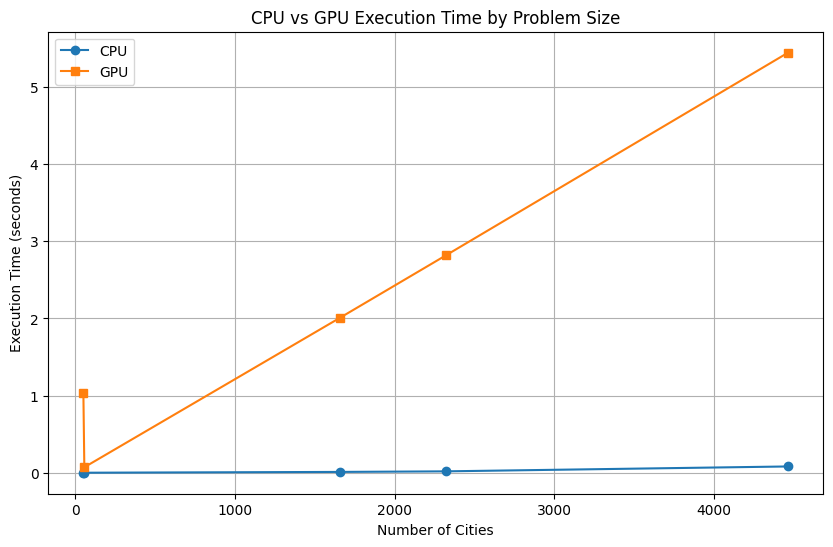

In [14]:
sorted_df = nn_df.sort_values(by='NumCities')
plt.figure(figsize=(10,6))
plt.plot(sorted_df['NumCities'], sorted_df['CPU_AvgTime'], 'o-', label='CPU')
plt.plot(sorted_df['NumCities'], sorted_df['GPU_AvgTime'], 's-', label='GPU')
plt.xlabel('Number of Cities')
plt.ylabel('Execution Time (seconds)')
plt.title('CPU vs GPU Execution Time by Problem Size')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
Cnn_map = {}
for idx, row in nn_df.iterrows():
    instance_name = row['Instance']
    Cnn_map[instance_name] = row['CPU_Distance']

### ANT COLONY

In [16]:
def run_aco_cpu(dist_matrix, Cnn, alpha=1.0, beta=2.0, rho=0.5, q0=0.9, xi=0.1, iterations=20, seed=42):
    np.random.seed(seed)
    num_cities = dist_matrix.shape[0]
    num_ants = num_cities

    tau0 = 1.0 / (num_cities * Cnn)
    pheromone = np.full((num_cities, num_cities), tau0, dtype=np.float32)

    eta = np.zeros((num_cities, num_cities), dtype=np.float32)
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                eta[i,j] = 1.0 / dist_matrix[i,j]

    best_distance = float('inf')
    best_path = None

    for it in range(iterations):
        all_paths = []
        all_distances = []

        for ant in range(num_ants):
            visited = np.zeros(num_cities, dtype=bool)
            path = []
            current_city = np.random.randint(num_cities)
            path.append(current_city)
            visited[current_city] = True

            for _ in range(num_cities - 1):
                unvisited = np.where(~visited)[0]
                tau = pheromone[current_city, unvisited]
                etas = eta[current_city, unvisited]

                values = (tau ** alpha) * (etas ** beta)
                best_idx = np.argmax(values)
                best_city = unvisited[best_idx]

                q = np.random.rand()
                if q <= q0:
                    next_city = best_city
                else:
                    denom = np.sum(values)
                    probs = values / denom
                    next_city = np.random.choice(unvisited, p=probs)

                path.append(next_city)
                visited[next_city] = True

                pheromone_val = pheromone[current_city, next_city]
                pheromone[current_city, next_city] = (1 - xi)*pheromone_val + xi*tau0
                pheromone[next_city, current_city] = pheromone[current_city, next_city]

                current_city = next_city

            dist = 0.0
            for i in range(num_cities):
                dist += dist_matrix[path[i], path[(i+1) % num_cities]]

            all_paths.append(path)
            all_distances.append(dist)

            if dist < best_distance:
                best_distance = dist
                best_path = path.copy()

        pheromone *= (1.0 - rho)
        gb_path = best_path
        gb_dist = best_distance
        deposit = 1.0 / gb_dist
        for i in range(num_cities):
            c1 = gb_path[i]
            c2 = gb_path[(i+1) % num_cities]
            pheromone[c1, c2] += deposit
            pheromone[c2, c1] += deposit

        print(f"Iteration {it+1}/{iterations}, Best Distance: {best_distance:.2f}")

    return best_path, best_distance

In [ ]:
aco_cpu_results = []
for name, dist_matrix in distance_matrices.items():
    if name in Cnn_map:
        Cnn = Cnn_map[name]
    else:
        print(f"No Cnn found for {name}, skipping ACO.")
        continue

    print(f"\nRunning ACO (CPU) with tau0 = 1/(n*Cnn) for {name} ({dist_matrix.shape[0]} cities)...")
    start_time = time.time()
    best_path, best_dist = run_aco_cpu(dist_matrix, Cnn=Cnn, alpha=1.0, beta=2.0, rho=0.5, iterations=20, seed=42)
    end_time = time.time()

    print(f"ACO Best Distance for {name}: {best_dist:.2f}")
    print(f"ACO Best Path: {best_path}")
    print(f"ACO Execution Time: {end_time - start_time:.4f}s")

    aco_cpu_results.append({
        'Instance': name,
        'NumCities': dist_matrix.shape[0],
        'BestDistance': best_dist,
        'Time': end_time - start_time
    })

df_aco_cpu = pd.DataFrame(aco_cpu_results)
df_aco_cpu


Running ACO (CPU) with tau0 = 1/(n*Cnn) for berlin52 (52 cities)...
Iteration 1/20, Best Distance: 8933.20
Iteration 2/20, Best Distance: 8504.07
Iteration 3/20, Best Distance: 8092.37
Iteration 4/20, Best Distance: 8061.31
Iteration 5/20, Best Distance: 8044.22
Iteration 6/20, Best Distance: 8044.22
Iteration 7/20, Best Distance: 8044.22
Iteration 8/20, Best Distance: 8044.22
Iteration 9/20, Best Distance: 8044.22
Iteration 10/20, Best Distance: 8044.22
Iteration 11/20, Best Distance: 7988.45
Iteration 12/20, Best Distance: 7927.99
Iteration 13/20, Best Distance: 7927.99
Iteration 14/20, Best Distance: 7927.99
Iteration 15/20, Best Distance: 7927.99
Iteration 16/20, Best Distance: 7927.99
Iteration 17/20, Best Distance: 7927.99
Iteration 18/20, Best Distance: 7927.99
Iteration 19/20, Best Distance: 7927.99
Iteration 20/20, Best Distance: 7927.99
ACO Best Distance for berlin52: 7927.99
ACO Best Path: [20, 30, 17, 2, 16, 6, 1, 41, 29, 28, 15, 49, 19, 22, 43, 45, 33, 34, 35, 38, 36, 39,

,Instance,NumCities,BestDistance,Time
0,berlin52,52,7927.994936,1.075595
1,brazil58,58,26245.000000,1.307172
2,d1655,1655,78426.822090,1595.651324
3,u2319,2319,289610.036591,3554.432596
4,fnl4461,4461,236643.565567,17816.840912


In [17]:
@cuda.jit(device=True)
def select_next_city(num_cities, current_city, visited, d_pheromone, d_eta,
                     alpha, beta, q0, q, choice_val):
    best_val = float32(0.0)
    best_city = -1
    total = float32(0.0)

    for c in range(num_cities):
        if not visited[c]:
            t = d_pheromone[current_city, c]
            e = d_eta[current_city, c]
            val = (t**alpha)*(e**beta)
            total += val
            if best_city == -1 or val > best_val:
                best_val = val
                best_city = c

    if q <= q0:
        # Exploitation
        return best_city
    else:
        # Exploration using roulette wheel selection
        threshold = choice_val * total
        partial_sum = float32(0.0)
        for c in range(num_cities):
            if not visited[c]:
                t = d_pheromone[current_city, c]
                e = d_eta[current_city, c]
                val = (t**alpha)*(e**beta)
                partial_sum += val
                if partial_sum >= threshold:
                    return c

        return best_city

@cuda.jit
def construct_solutions_kernel(d_dist_matrix, d_pheromone, d_eta,
                               alpha, beta, q0, xi, tau0,
                               d_paths, d_distances, d_visited_arrays,
                               d_random_numbers,
                               num_cities, num_ants):
    ant_id = cuda.grid(1)
    if ant_id < num_ants:
        start_visited = ant_id * num_cities
        visited = d_visited_arrays[start_visited:start_visited+num_cities]

        for i in range(num_cities):
            visited[i] = False

        offset = ant_id * (2*num_cities)

        start_city = int(d_random_numbers[offset] * num_cities)
        d_paths[ant_id, 0] = start_city
        visited[start_city] = True
        current_city = start_city

        for step in range(1, num_cities):
            q = d_random_numbers[offset + (step*2 - 1)]
            choice_val = d_random_numbers[offset + (step*2)]
            next_city = select_next_city(num_cities, current_city, visited, d_pheromone, d_eta,
                                         alpha, beta, q0, q, choice_val)
            d_paths[ant_id, step] = next_city
            visited[next_city] = True

            old_val = d_pheromone[current_city, next_city]
            new_val = (1 - xi)*old_val + xi*tau0
            delta = new_val - old_val
            cuda.atomic.add(d_pheromone, (current_city, next_city), delta)
            cuda.atomic.add(d_pheromone, (next_city, current_city), delta)

            current_city = next_city

        dist = 0.0
        for i in range(num_cities):
            c1 = d_paths[ant_id, i]
            c2 = d_paths[ant_id, (i+1) % num_cities]
            dist += d_dist_matrix[c1, c2]
        d_distances[ant_id] = dist

@cuda.jit
def global_evaporation_kernel(d_pheromone, rho, num_cities):
    i, j = cuda.grid(2)
    if i < num_cities and j < num_cities:
        old_val = d_pheromone[i,j]
        new_val = old_val * (1.0 - rho)
        d_pheromone[i,j] = new_val

@cuda.jit
def global_deposit_kernel(d_pheromone, gb_path, gb_dist, num_cities):
    deposit = 1.0 / gb_dist
    i = cuda.grid(1)
    if i < num_cities:
        c1 = gb_path[i]
        c2 = gb_path[(i+1) % num_cities]
        cuda.atomic.add(d_pheromone, (c1, c2), deposit)
        cuda.atomic.add(d_pheromone, (c2, c1), deposit)

def run_aco_gpu_simple(dist_matrix, Cnn, alpha=1.0, beta=2.0, rho=0.5, q0=0.9, xi=0.1, iterations=20, seed=42):
    np.random.seed(seed)
    num_cities = dist_matrix.shape[0]
    num_ants = num_cities

    tau0 = 1.0 / (num_cities * Cnn)
    pheromone = np.full((num_cities, num_cities), tau0, dtype=np.float32)

    eta = np.zeros((num_cities, num_cities), dtype=np.float32)
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                eta[i,j] = 1.0 / dist_matrix[i,j]

    d_dist_matrix = cuda.to_device(dist_matrix.astype(np.float32))
    d_pheromone = cuda.to_device(pheromone)
    d_eta = cuda.to_device(eta)

    d_paths = cuda.device_array((num_ants, num_cities), dtype=np.int32)
    d_distances = cuda.device_array(num_ants, dtype=np.float32)
    d_visited_arrays = cuda.device_array(num_ants * num_cities, dtype=np.bool_)

    rand_count = 2 * num_cities * num_ants + num_ants
    random_numbers = np.random.rand(rand_count).astype(np.float32)
    d_random_numbers = cuda.to_device(random_numbers)

    threads_per_block = 256
    blocks_per_grid = (num_ants + threads_per_block - 1) // threads_per_block

    block_dim_2d = (16,16)
    grid_dim_2d = ((num_cities + block_dim_2d[0]-1)//block_dim_2d[0],
                    (num_cities + block_dim_2d[1]-1)//block_dim_2d[1])

    best_distance = float('inf')
    best_path = None

    d_gb_path = cuda.device_array(num_cities, dtype=np.int32)

    for it in range(iterations):
        construct_solutions_kernel[blocks_per_grid, threads_per_block](
            d_dist_matrix, d_pheromone, d_eta,
            float32(alpha), float32(beta), float32(q0), float32(xi), float32(tau0),
            d_paths, d_distances, d_visited_arrays,
            d_random_numbers,
            num_cities, num_ants)

        paths = d_paths.copy_to_host()
        distances = d_distances.copy_to_host()
        iteration_best_idx = np.argmin(distances)
        iteration_best_dist = distances[iteration_best_idx]
        iteration_best_path = paths[iteration_best_idx].copy()

        if iteration_best_dist < best_distance:
            best_distance = iteration_best_dist
            best_path = iteration_best_path.copy()

        global_evaporation_kernel[grid_dim_2d, block_dim_2d](d_pheromone, float32(rho), num_cities)

        d_gb_path.copy_to_device(best_path)
        global_deposit_kernel[blocks_per_grid, threads_per_block](d_pheromone, d_gb_path, float32(best_distance), num_cities)

        print(f"Iteration {it+1}/{iterations}, Best Distance: {best_distance:.2f}")

    return best_path, best_distance

In [ ]:
aco_gpu1_results = []

for name, dist_matrix in distance_matrices.items():
    if name not in Cnn_map:
        print(f"No Cnn found for {name}, skipping GPU ACO.")
        continue

    Cnn = Cnn_map[name]
    num_cities = dist_matrix.shape[0]
    print(f"\nRunning ACO (GPU) for {name} ({num_cities} cities)...")

    start_time = time.time()
    best_path, best_dist = run_aco_gpu_simple(dist_matrix, Cnn, alpha=alpha, beta=beta,
                                              rho=rho, q0=q0, xi=xi, iterations=iterations, seed=seed)
    end_time = time.time()

    print(f"ACO (GPU) Best Distance for {name}: {best_dist:.2f}")
    print(f"ACO (GPU) Best Path: {best_path}")
    print(f"ACO (GPU) Execution Time: {end_time - start_time:.4f}s")

    aco_gpu1_results.append({
        'Instance': name,
        'NumCities': num_cities,
        'BestDistance': best_dist,
        'Time': end_time - start_time
    })

df_aco_gpu1 = pd.DataFrame(aco_gpu1_results)
df_aco_gpu1


Running ACO (GPU) for berlin52 (52 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 8566.19
Iteration 2/20, Best Distance: 8064.25
Iteration 3/20, Best Distance: 8041.79
Iteration 4/20, Best Distance: 7936.73
Iteration 5/20, Best Distance: 7893.63
Iteration 6/20, Best Distance: 7893.63
Iteration 7/20, Best Distance: 7893.63
Iteration 8/20, Best Distance: 7893.63
Iteration 9/20, Best Distance: 7893.63
Iteration 10/20, Best Distance: 7893.63
Iteration 11/20, Best Distance: 7893.63
Iteration 12/20, Best Distance: 7893.63
Iteration 13/20, Best Distance: 7893.63
Iteration 14/20, Best Distance: 7893.63
Iteration 15/20, Best Distance: 7893.63
Iteration 16/20, Best Distance: 7893.63
Iteration 17/20, Best Distance: 7893.63
Iteration 18/20, Best Distance: 7893.63
Iteration 19/20, Best Distance: 7893.63
Iteration 20/20, Best Distance: 7893.63
ACO (GPU) Best Distance for berlin52: 7893.63
ACO (GPU) Best Path: [38 35 34 33 43 45 15 28 22 49 19 20 29  1  6 41 16  2 17 30 21  0 48 31
 44 18 40  7  8  9 42 32 50 10 51 13 12 46 25 26 27 11 24  3  5 14  4

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 101769.19
Iteration 2/20, Best Distance: 92718.83
Iteration 3/20, Best Distance: 87293.36
Iteration 4/20, Best Distance: 84006.34
Iteration 5/20, Best Distance: 82045.62
Iteration 6/20, Best Distance: 82000.00
Iteration 7/20, Best Distance: 80959.23
Iteration 8/20, Best Distance: 80428.37
Iteration 9/20, Best Distance: 80428.37
Iteration 10/20, Best Distance: 78489.09
Iteration 11/20, Best Distance: 78489.09
Iteration 12/20, Best Distance: 78489.09
Iteration 13/20, Best Distance: 78489.09
Iteration 14/20, Best Distance: 78489.09
Iteration 15/20, Best Distance: 78489.09
Iteration 16/20, Best Distance: 78489.09
Iteration 17/20, Best Distance: 78489.09
Iteration 18/20, Best Distance: 78489.09
Iteration 19/20, Best Distance: 78489.09
Iteration 20/20, Best Distance: 78489.09
ACO (GPU) Best Distance for d1655: 78489.09
ACO (GPU) Best Path: [1257 1258 1259 ...  992  972  963]
ACO (GPU) Execution Time: 73.0979s

Running ACO (GPU) for u2319 (2319 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 376379.16
Iteration 2/20, Best Distance: 350922.47
Iteration 3/20, Best Distance: 333357.94
Iteration 4/20, Best Distance: 315245.59
Iteration 5/20, Best Distance: 303639.56
Iteration 6/20, Best Distance: 294758.56
Iteration 7/20, Best Distance: 294758.56
Iteration 8/20, Best Distance: 294284.47
Iteration 9/20, Best Distance: 293022.84
Iteration 10/20, Best Distance: 290865.53
Iteration 11/20, Best Distance: 290865.53
Iteration 12/20, Best Distance: 290865.53
Iteration 13/20, Best Distance: 290865.53
Iteration 14/20, Best Distance: 290865.53
Iteration 15/20, Best Distance: 290865.53
Iteration 16/20, Best Distance: 290865.53
Iteration 17/20, Best Distance: 290865.53
Iteration 18/20, Best Distance: 290865.53
Iteration 19/20, Best Distance: 290865.53
Iteration 20/20, Best Distance: 287585.12
ACO (GPU) Best Distance for u2319: 287585.12
ACO (GPU) Best Path: [ 855  854 1020 ...  948  950 1431]
ACO (GPU) Execution Time: 176.4380s

Running ACO (GPU) for fnl4461 

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 344283.97
Iteration 2/20, Best Distance: 316926.69
Iteration 3/20, Best Distance: 287909.50
Iteration 4/20, Best Distance: 266599.38
Iteration 5/20, Best Distance: 254249.75
Iteration 6/20, Best Distance: 247897.33
Iteration 7/20, Best Distance: 244614.11
Iteration 8/20, Best Distance: 240323.05
Iteration 9/20, Best Distance: 240323.05
Iteration 10/20, Best Distance: 240323.05
Iteration 11/20, Best Distance: 240323.05
Iteration 12/20, Best Distance: 240161.14
Iteration 13/20, Best Distance: 239437.36
Iteration 14/20, Best Distance: 239437.36
Iteration 15/20, Best Distance: 239437.36
Iteration 16/20, Best Distance: 239437.36
Iteration 17/20, Best Distance: 239437.36
Iteration 18/20, Best Distance: 239437.36
Iteration 19/20, Best Distance: 239437.36
Iteration 20/20, Best Distance: 239437.36
ACO (GPU) Best Distance for fnl4461: 239437.36
ACO (GPU) Best Path: [ 718  777  824 ... 4423 4439 4371]
ACO (GPU) Execution Time: 724.6412s


,Instance,NumCities,BestDistance,Time
0,berlin52,52,7893.633789,0.772556
1,brazil58,58,26428.000000,0.106471
2,d1655,1655,78489.085938,73.097919
3,u2319,2319,287585.125000,176.437990
4,fnl4461,4461,239437.359375,724.641156


In [18]:
@cuda.jit(device=True)
def select_next_city(num_cities, current_city, visited, shared_mem,
                     alpha, beta, q0, q, choice_val):
    best_val = float32(0.0)
    best_city = -1
    total = float32(0.0)

    for c in range(num_cities):
        if not visited[c]:
            t = shared_mem[c]
            e = shared_mem[num_cities + c]
            val = (t**alpha)*(e**beta)
            total += val
            if best_city == -1 or val > best_val:
                best_val = val
                best_city = c

    if q <= q0:
        return best_city
    else:
        threshold = choice_val * total
        partial_sum = float32(0.0)
        for c in range(num_cities):
            if not visited[c]:
                t = shared_mem[c]
                e = shared_mem[num_cities + c]
                val = (t**alpha)*(e**beta)
                partial_sum += val
                if partial_sum >= threshold:
                    return c
        return best_city


@cuda.jit
def construct_solutions_kernel(d_dist_matrix, d_pheromone, d_eta,
                               alpha, beta, q0, xi, tau0,
                               d_paths, d_distances, d_visited_arrays,
                               d_random_numbers,
                               num_cities, num_ants):
    shared_mem = cuda.shared.array(shape=0, dtype=float32)
    ant_id = cuda.grid(1)

    if ant_id < num_ants:
        start_visited = ant_id * num_cities
        visited = d_visited_arrays[start_visited:start_visited+num_cities]

        for i in range(num_cities):
            visited[i] = False

        offset = ant_id * (2*num_cities)

        start_city = int(d_random_numbers[offset] * num_cities)
        d_paths[ant_id, 0] = start_city
        visited[start_city] = True
        current_city = start_city

        for step in range(1, num_cities):
            for c in range(num_cities):
                shared_mem[c] = d_pheromone[current_city, c]
            for c in range(num_cities):
                shared_mem[num_cities + c] = d_eta[current_city, c]

            cuda.syncthreads()

            q = d_random_numbers[offset + (step*2 - 1)]
            choice_val = d_random_numbers[offset + (step*2)]

            next_city = select_next_city(num_cities, current_city, visited, shared_mem,
                                         alpha, beta, q0, q, choice_val)
            d_paths[ant_id, step] = next_city
            visited[next_city] = True

            old_val = d_pheromone[current_city, next_city]
            new_val = (1 - xi)*old_val + xi*tau0
            delta = new_val - old_val
            cuda.atomic.add(d_pheromone, (current_city, next_city), delta)
            cuda.atomic.add(d_pheromone, (next_city, current_city), delta)

            current_city = next_city

        dist = 0.0
        for i in range(num_cities):
            c1 = d_paths[ant_id, i]
            c2 = d_paths[ant_id, (i+1) % num_cities]
            dist += d_dist_matrix[c1, c2]
        d_distances[ant_id] = dist

@cuda.jit
def global_evaporation_kernel(d_pheromone, rho, num_cities):
    i, j = cuda.grid(2)
    if i < num_cities and j < num_cities:
        old_val = d_pheromone[i,j]
        d_pheromone[i,j] = old_val * (1.0 - rho)

@cuda.jit
def global_deposit_kernel(d_pheromone, gb_path, gb_dist, num_cities):
    deposit = 1.0 / gb_dist
    i = cuda.grid(1)
    if i < num_cities:
        c1 = gb_path[i]
        c2 = gb_path[(i+1) % num_cities]
        cuda.atomic.add(d_pheromone, (c1, c2), deposit)
        cuda.atomic.add(d_pheromone, (c2, c1), deposit)

def run_aco_gpu_advanced(dist_matrix, Cnn, alpha=1.0, beta=2.0, rho=0.5, q0=0.9, xi=0.1, iterations=20, seed=42):
    np.random.seed(seed)
    num_cities = dist_matrix.shape[0]
    num_ants = num_cities

    tau0 = 1.0 / (num_cities * Cnn)
    pheromone = np.full((num_cities, num_cities), tau0, dtype=np.float32)

    eta = np.zeros((num_cities, num_cities), dtype=np.float32)
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                eta[i,j] = 1.0 / dist_matrix[i,j]

    d_dist_matrix = cuda.to_device(dist_matrix.astype(np.float32))
    d_pheromone = cuda.to_device(pheromone)
    d_eta = cuda.to_device(eta)

    d_paths = cuda.device_array((num_ants, num_cities), dtype=np.int32)
    d_distances = cuda.device_array(num_ants, dtype=np.float32)
    d_visited_arrays = cuda.device_array(num_ants * num_cities, dtype=np.bool_)

    rand_count = 2 * num_cities * num_ants + num_ants

    threads_per_block = 256
    blocks_per_grid = (num_ants + threads_per_block - 1) // threads_per_block

    block_dim_2d = (16,16)
    grid_dim_2d = ((num_cities + block_dim_2d[0]-1)//block_dim_2d[0],
                   (num_cities + block_dim_2d[1]-1)//block_dim_2d[1])

    best_distance = float('inf')
    best_path = None
    d_gb_path = cuda.device_array(num_cities, dtype=np.int32)

    shared_mem_size = 2 * num_cities * 4

    for it in range(iterations):
        random_numbers = np.random.rand(rand_count).astype(np.float32)
        d_random_numbers = cuda.to_device(random_numbers)

        construct_solutions_kernel[blocks_per_grid, threads_per_block, 0, shared_mem_size](
            d_dist_matrix, d_pheromone, d_eta,
            float32(alpha), float32(beta), float32(q0), float32(xi), float32(tau0),
            d_paths, d_distances, d_visited_arrays,
            d_random_numbers,
            num_cities, num_ants)

        paths = d_paths.copy_to_host()
        distances = d_distances.copy_to_host()
        iteration_best_idx = np.argmin(distances)
        iteration_best_dist = distances[iteration_best_idx]
        iteration_best_path = paths[iteration_best_idx].copy()

        if iteration_best_dist < best_distance:
            best_distance = iteration_best_dist
            best_path = iteration_best_path.copy()

        global_evaporation_kernel[grid_dim_2d, block_dim_2d](d_pheromone, float32(rho), num_cities)

        d_gb_path.copy_to_device(best_path)
        global_deposit_kernel[blocks_per_grid, threads_per_block](d_pheromone, d_gb_path, float32(best_distance), num_cities)

        print(f"Iteration {it+1}/{iterations}, Best Distance: {best_distance:.2f}")

    return best_path, best_distance


In [ ]:
alpha = 1.0
beta = 2.0
rho = 0.5
q0 = 0.9
xi = 0.1
iterations = 20
seed = 42

aco_gpu2_results = []

for name, dist_matrix in distance_matrices.items():
    if name not in Cnn_map:
        print(f"No Cnn found for {name}, skipping GPU ACO.")
        continue

    Cnn = Cnn_map[name]
    num_cities = dist_matrix.shape[0]
    print(f"\nRunning Advanced ACO (GPU) for {name} ({num_cities} cities)...")

    start_time = time.time()
    best_path, best_dist = run_aco_gpu_advanced(dist_matrix, Cnn, alpha=alpha, beta=beta,
                                                rho=rho, q0=q0, xi=xi, iterations=iterations, seed=seed)
    end_time = time.time()

    print(f"Advanced ACO (GPU) Best Distance for {name}: {best_dist:.2f}")
    print(f"Advanced ACO (GPU) Best Path: {best_path}")
    print(f"Advanced ACO (GPU) Execution Time: {end_time - start_time:.4f}s")

    aco_gpu2_results.append({
        'Instance': name,
        'NumCities': num_cities,
        'BestDistance': best_dist,
        'Time': end_time - start_time
    })

df_aco2_gpu = pd.DataFrame(aco_gpu2_results)
df_aco2_gpu


Running Advanced ACO (GPU) for berlin52 (52 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 11040.68
Iteration 2/20, Best Distance: 11040.68
Iteration 3/20, Best Distance: 11040.68
Iteration 4/20, Best Distance: 11040.68
Iteration 5/20, Best Distance: 11040.68
Iteration 6/20, Best Distance: 11040.68
Iteration 7/20, Best Distance: 11040.68
Iteration 8/20, Best Distance: 11040.68
Iteration 9/20, Best Distance: 11040.68
Iteration 10/20, Best Distance: 10573.70
Iteration 11/20, Best Distance: 10573.70
Iteration 12/20, Best Distance: 10573.70
Iteration 13/20, Best Distance: 10573.70
Iteration 14/20, Best Distance: 10573.70
Iteration 15/20, Best Distance: 10573.70
Iteration 16/20, Best Distance: 10573.70
Iteration 17/20, Best Distance: 10573.70
Iteration 18/20, Best Distance: 10573.70
Iteration 19/20, Best Distance: 10573.70
Iteration 20/20, Best Distance: 10573.70
Advanced ACO (GPU) Best Distance for berlin52: 10573.70
Advanced ACO (GPU) Best Path: [43 31 48  0 21 30 17  2 16 20 22 19 15 49 33 34 35 38 39 37 36 47 23  4
 14  3  5 24 11 45 42 32 50 27

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 203998.48
Iteration 2/20, Best Distance: 203998.48
Iteration 3/20, Best Distance: 203998.48
Iteration 4/20, Best Distance: 203998.48
Iteration 5/20, Best Distance: 203998.48
Iteration 6/20, Best Distance: 203998.48
Iteration 7/20, Best Distance: 203998.48
Iteration 8/20, Best Distance: 203998.48
Iteration 9/20, Best Distance: 203998.48
Iteration 10/20, Best Distance: 203998.48
Iteration 11/20, Best Distance: 203998.48
Iteration 12/20, Best Distance: 203998.48
Iteration 13/20, Best Distance: 203998.48
Iteration 14/20, Best Distance: 203998.48
Iteration 15/20, Best Distance: 203998.48
Iteration 16/20, Best Distance: 203998.48
Iteration 17/20, Best Distance: 203998.48
Iteration 18/20, Best Distance: 203998.48
Iteration 19/20, Best Distance: 203998.48
Iteration 20/20, Best Distance: 203998.48
Advanced ACO (GPU) Best Distance for d1655: 203998.48
Advanced ACO (GPU) Best Path: [1456  371  362 ...  102   68    0]
Advanced ACO (GPU) Execution Time: 51.2445s

Runn

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 417809.66
Iteration 2/20, Best Distance: 417809.66
Iteration 3/20, Best Distance: 417809.66
Iteration 4/20, Best Distance: 417809.66
Iteration 5/20, Best Distance: 417809.66
Iteration 6/20, Best Distance: 417809.66
Iteration 7/20, Best Distance: 417809.66
Iteration 8/20, Best Distance: 417809.66
Iteration 9/20, Best Distance: 417809.66
Iteration 10/20, Best Distance: 417809.66
Iteration 11/20, Best Distance: 417809.66
Iteration 12/20, Best Distance: 417809.66
Iteration 13/20, Best Distance: 417809.66
Iteration 14/20, Best Distance: 417809.66
Iteration 15/20, Best Distance: 417809.66
Iteration 16/20, Best Distance: 417809.66
Iteration 17/20, Best Distance: 417809.66
Iteration 18/20, Best Distance: 417809.66
Iteration 19/20, Best Distance: 417809.66
Iteration 20/20, Best Distance: 417809.66
Advanced ACO (GPU) Best Distance for u2319: 417809.66
Advanced ACO (GPU) Best Path: [1724 1718 1716 ... 1703 1709 1687]
Advanced ACO (GPU) Execution Time: 104.8883s

Run

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 637283.38
Iteration 2/20, Best Distance: 637283.38
Iteration 3/20, Best Distance: 637283.38
Iteration 4/20, Best Distance: 637283.38
Iteration 5/20, Best Distance: 637283.38
Iteration 6/20, Best Distance: 637283.38
Iteration 7/20, Best Distance: 637283.38
Iteration 8/20, Best Distance: 637283.38
Iteration 9/20, Best Distance: 637283.38
Iteration 10/20, Best Distance: 637283.38
Iteration 11/20, Best Distance: 637283.38
Iteration 12/20, Best Distance: 637283.38
Iteration 13/20, Best Distance: 637283.38
Iteration 14/20, Best Distance: 637283.38
Iteration 15/20, Best Distance: 637283.38
Iteration 16/20, Best Distance: 637283.38
Iteration 17/20, Best Distance: 637283.38
Iteration 18/20, Best Distance: 637283.38
Iteration 19/20, Best Distance: 637283.38
Iteration 20/20, Best Distance: 637283.38
Advanced ACO (GPU) Best Distance for fnl4461: 637283.38
Advanced ACO (GPU) Best Path: [ 820  798  770 ...  250    2 4434]
Advanced ACO (GPU) Execution Time: 446.5150s


,Instance,NumCities,BestDistance,Time
0,berlin52,52,10573.698242,0.957145
1,brazil58,58,34856.000000,0.092347
2,d1655,1655,203998.484375,51.244519
3,u2319,2319,417809.656250,104.888310
4,fnl4461,4461,637283.375000,446.514983


### HELD KARP W/ OTHER ALGORITHMS SYNTHETIC

In [ ]:
from itertools import combinations

num_cities = 20
np.random.seed(42)
coords = np.random.rand(num_cities, 2) * 1000

tsp_filename = "synthetic10.tsp"
with open(tsp_filename, 'w') as f:
    f.write("NAME: synthetic10\n")
    f.write("TYPE: TSP\n")
    f.write(f"DIMENSION: {num_cities}\n")
    f.write("EDGE_WEIGHT_TYPE: EUC_2D\n")
    f.write("NODE_COORD_SECTION\n")
    for i in range(num_cities):
        f.write(f"{i+1} {coords[i,0]} {coords[i,1]}\n")
    f.write("EOF\n")

synthetic_dist_matrix = load_tsp(tsp_filename)

from itertools import combinations

def held_karp(dist_matrix):
    n = dist_matrix.shape[0]
    dp = np.full((1 << (n-1), n), np.inf, dtype=np.float64)
    dp[0][0] = 0.0

    for mask in range(1 << (n-1)):
        for i in range(n):
            if dp[mask][i] == np.inf:
                continue
            for j in range(1, n):
                if (mask & (1 << (j-1))) == 0:
                    next_mask = mask | (1 << (j-1))
                    new_cost = dp[mask][i] + dist_matrix[i][j]
                    if new_cost < dp[next_mask][j]:
                        dp[next_mask][j] = new_cost

    full_mask = (1 << (n-1)) - 1
    res = np.inf
    for j in range(1, n):
        res = min(res, dp[full_mask][j] + dist_matrix[j][0])
    return res

def run_nn_cpu(dist_matrix, trials=3):
    times = []
    best_dist = None
    for _ in range(trials):
        start = time.time()
        path, dist_val = nearest_neighbor_tsp_matrix(dist_matrix)
        end = time.time()
        times.append(end - start)
        best_dist = dist_val
    return np.mean(times), best_dist

def run_nn_gpu(dist_matrix, trials=3):
    times = []
    best_dist = None
    for _ in range(trials):
        start = time.time()
        path, dist_val = nearest_neighbor_tsp_gpu_matrix(dist_matrix)
        end = time.time()
        times.append(end - start)
        best_dist = dist_val
    return np.mean(times), best_dist

def run_aco_cpu_wrapper(dist_matrix, iterations=20, seed=42):
    _, nn_dist = nearest_neighbor_tsp_matrix(dist_matrix)
    start = time.time()
    best_path, best_dist = run_aco_cpu(dist_matrix, Cnn=nn_dist, alpha=1.0, beta=2.0, rho=0.5, iterations=iterations, seed=seed)
    end = time.time()
    return end - start, best_dist

def run_aco_gpu_wrapper(dist_matrix, advanced=False, iterations=20, seed=42):
    _, nn_dist = nearest_neighbor_tsp_matrix(dist_matrix)
    start = time.time()
    if advanced:
        best_path, best_dist = run_aco_gpu_advanced(dist_matrix, Cnn=nn_dist, alpha=1.0, beta=2.0, rho=0.5, q0=0.9, xi=0.1, iterations=iterations, seed=seed)
    else:
        best_path, best_dist = run_aco_gpu_simple(dist_matrix, Cnn=nn_dist, alpha=1.0, beta=2.0, rho=0.5, q0=0.9, xi=0.1, iterations=iterations, seed=seed)
    end = time.time()
    return end - start, best_dist

def run_held_karp_wrapper(dist_matrix):
    start = time.time()
    best_dist = held_karp(dist_matrix)
    end = time.time()
    return end - start, best_dist

results = []
nn_cpu_time, nn_cpu_dist = run_nn_cpu(synthetic_dist_matrix)
results.append({
    'Algorithm': 'NearestNeighbor_CPU',
    'NumCities': num_cities,
    'Time': nn_cpu_time,
    'Distance': nn_cpu_dist
})

nn_gpu_time, nn_gpu_dist = run_nn_gpu(synthetic_dist_matrix)
results.append({
    'Algorithm': 'NearestNeighbor_GPU',
    'NumCities': num_cities,
    'Time': nn_gpu_time,
    'Distance': nn_gpu_dist
})

aco_cpu_time, aco_cpu_dist = run_aco_cpu_wrapper(synthetic_dist_matrix)
results.append({
    'Algorithm': 'ACO_CPU',
    'NumCities': num_cities,
    'Time': aco_cpu_time,
    'Distance': aco_cpu_dist
})

aco_gpu_simple_time, aco_gpu_simple_dist = run_aco_gpu_wrapper(synthetic_dist_matrix, advanced=False)
results.append({
    'Algorithm': 'ACO_GPU_Simple',
    'NumCities': num_cities,
    'Time': aco_gpu_simple_time,
    'Distance': aco_gpu_simple_dist
})

aco_gpu_adv_time, aco_gpu_adv_dist = run_aco_gpu_wrapper(synthetic_dist_matrix, advanced=True)
results.append({
    'Algorithm': 'ACO_GPU_Advanced',
    'NumCities': num_cities,
    'Time': aco_gpu_adv_time,
    'Distance': aco_gpu_adv_dist
})

hk_time, hk_dist = run_held_karp_wrapper(synthetic_dist_matrix)
results.append({
    'Algorithm': 'HeldKarp',
    'NumCities': num_cities,
    'Time': hk_time,
    'Distance': hk_dist
})

df_results = pd.DataFrame(results)
df_results

Iteration 1/20, Best Distance: 4614.34
Iteration 2/20, Best Distance: 4614.34
Iteration 3/20, Best Distance: 4614.34
Iteration 4/20, Best Distance: 4614.34
Iteration 5/20, Best Distance: 4614.34
Iteration 6/20, Best Distance: 4614.34
Iteration 7/20, Best Distance: 4614.34
Iteration 8/20, Best Distance: 4614.34
Iteration 9/20, Best Distance: 4614.34
Iteration 10/20, Best Distance: 4614.34
Iteration 11/20, Best Distance: 4614.34
Iteration 12/20, Best Distance: 4614.34
Iteration 13/20, Best Distance: 4614.34
Iteration 14/20, Best Distance: 4614.34
Iteration 15/20, Best Distance: 4614.34
Iteration 16/20, Best Distance: 4614.34
Iteration 17/20, Best Distance: 4614.34
Iteration 18/20, Best Distance: 4614.34
Iteration 19/20, Best Distance: 4614.34
Iteration 20/20, Best Distance: 4614.34


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Iteration 1/20, Best Distance: 4971.27
Iteration 2/20, Best Distance: 4971.27
Iteration 3/20, Best Distance: 4971.27
Iteration 4/20, Best Distance: 4971.27
Iteration 5/20, Best Distance: 4971.27
Iteration 6/20, Best Distance: 4971.27
Iteration 7/20, Best Distance: 4971.27
Iteration 8/20, Best Distance: 4971.27
Iteration 9/20, Best Distance: 4971.27
Iteration 10/20, Best Distance: 4971.27
Iteration 11/20, Best Distance: 4971.27
Iteration 12/20, Best Distance: 4971.27
Iteration 13/20, Best Distance: 4971.27
Iteration 14/20, Best Distance: 4971.27
Iteration 15/20, Best Distance: 4971.27
Iteration 16/20, Best Distance: 4971.27
Iteration 17/20, Best Distance: 4971.27
Iteration 18/20, Best Distance: 4971.27
Iteration 19/20, Best Distance: 4971.27
Iteration 20/20, Best Distance: 4971.27
Iteration 1/20, Best Distance: 4971.27
Iteration 2/20, Best Distance: 4971.27
Iteration 3/20, Best Distance: 4864.72
Iteration 4/20, Best Distance: 4864.72
Iteration 5/20, Best Distance: 4864.72
Iteration 6/20

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


             Algorithm  NumCities       Time     Distance
0  NearestNeighbor_CPU         20   0.000125  4650.384214
1  NearestNeighbor_GPU         20   0.023215  4650.384277
2              ACO_CPU         20   0.167437  4614.336660
3       ACO_GPU_Simple         20   0.787522  4971.268066
4     ACO_GPU_Advanced         20   0.037710  4864.715332
5             HeldKarp         20  65.198289  3864.296881


### GENETIC ALGORITHM

In [16]:
def build_nn_route(dist_matrix, start_city=0):
    num_cities = dist_matrix.shape[0]
    visited = np.zeros(num_cities, dtype=bool)
    route = [start_city]
    visited[start_city] = True
    current_city = start_city

    for _ in range(num_cities - 1):
        unvisited = np.where(~visited)[0]
        dists = dist_matrix[current_city, unvisited]
        next_city_idx = np.argmin(dists)
        next_city = unvisited[next_city_idx]
        route.append(next_city)
        visited[next_city] = True
        current_city = next_city

    return np.array(route, dtype=np.int32)

def get_dynamic_parameters(num_cities):
    pop_size = num_cities
    num_generations = 2 * num_cities
    crossover_rate = 0.9
    base_mutation_rate = 0.02
    num_elites = max(1, pop_size // 20)
    return pop_size, num_generations, crossover_rate, base_mutation_rate, num_elites

def compute_fitness_cpu(population, dist_matrix):
    pop_size_local, num_cities = population.shape
    fitness = np.zeros(pop_size_local, dtype=np.float32)
    for i in range(pop_size_local):
        dist_sum = 0.0
        route = population[i]
        for c in range(num_cities):
            c1 = route[c]
            c2 = route[(c+1) % num_cities]
            dist_sum += dist_matrix[c1, c2]
        fitness[i] = dist_sum
    return fitness

@cuda.jit
def compute_fitness_gpu_kernel(population, dist_matrix, fitness, num_cities):
    tid = cuda.grid(1)
    if tid < fitness.shape[0]:
        dist_sum = 0.0
        for c in range(num_cities):
            c1 = population[tid, c]
            c2 = population[tid, (c+1) % num_cities]
            dist_sum += dist_matrix[c1, c2]
        fitness[tid] = dist_sum

def compute_fitness_gpu(population, dist_matrix):
    pop_size_local, num_cities = population.shape
    d_pop = cuda.to_device(population)
    d_dist = cuda.to_device(dist_matrix)
    d_fitness = cuda.device_array(pop_size_local, dtype=np.float32)

    threads_per_block = 256
    blocks = max(32, (pop_size_local + threads_per_block - 1) // threads_per_block)

    compute_fitness_gpu_kernel[blocks, threads_per_block](
        d_pop, d_dist, d_fitness, num_cities
    )

    return d_fitness.copy_to_host()


def tournament_selection(population, fitness, tournament_size=5):
    pop_size_local = len(population)
    selected = []
    while len(selected) < pop_size_local:
        idx = np.random.choice(pop_size_local, size=tournament_size, replace=False)
        best_idx = idx[np.argmin(fitness[idx])]
        selected.append(population[best_idx].copy())
    return np.array(selected, dtype=np.int32)

def get_elites(population, fitness, num_elites):
    idx = np.argsort(fitness)
    return population[idx[:num_elites]].copy()

def pmx_crossover(parent1, parent2):
    size = len(parent1)
    offspring = np.full(size, -1, dtype=np.int32)
    start, end = sorted(np.random.choice(range(size), size=2, replace=False))
    offspring[start:end+1] = parent1[start:end+1]
    mapping = {}
    for i in range(start, end+1):
        mapping[parent1[i]] = parent2[i]

    for i in range(size):
        if i < start or i > end:
            val = parent2[i]
            while val in mapping:
                val = mapping[val]
            offspring[i] = val

    return offspring

def adaptive_mutation(indiv, mutation_rate):
    """
    With probability 'mutation_rate', swap two genes in the individual.
    """
    if np.random.rand() < mutation_rate:
        i, j = np.random.randint(len(indiv), size=2)
        indiv[i], indiv[j] = indiv[j], indiv[i]

def run_ga_cpu(dist_matrix, seed=42):
    """
    GA on CPU with:
    - pop_size = num_cities
    - ~2 * num_cities generations
    - 20% of initial population seeded by NN solutions
    - partial replacement (keep top 50%)
    - tournament selection (size=5), PMX crossover, adaptive mutation
    """
    np.random.seed(seed)
    num_cities = dist_matrix.shape[0]
    pop_size, num_generations, crossover_rate, base_mutation_rate, num_elites = get_dynamic_parameters(num_cities)

    population = np.zeros((pop_size, num_cities), dtype=np.int32)
    num_nn = int(0.20 * pop_size)
    used_starts = set()
    for i in range(num_nn):
        while True:
            start = np.random.randint(num_cities)
            if start not in used_starts:
                used_starts.add(start)
                break
        nn_route = build_nn_route(dist_matrix, start_city=start)

        population[i] = nn_route
    for i in range(num_nn, pop_size):
        population[i] = np.random.permutation(num_cities)

    fitness = compute_fitness_cpu(population, dist_matrix)
    best_idx = np.argmin(fitness)
    best_global_dist = fitness[best_idx]
    best_global = population[best_idx].copy()

    start_time = time.time()

    no_improvement_count = 0
    mutation_rate = base_mutation_rate

    for gen in range(num_generations):
        idx_sorted = np.argsort(fitness)
        half_pop = pop_size // 2
        survivors = population[idx_sorted[:half_pop]]
        survivor_fitness = fitness[idx_sorted[:half_pop]]
        elites = survivors[:num_elites]
        selected_pop = tournament_selection(survivors, survivor_fitness, tournament_size=5)
        new_population = []
        new_population.extend(survivors)

        while len(new_population) < pop_size:
            if np.random.rand() < crossover_rate:
                p1 = selected_pop[np.random.randint(len(selected_pop))]
                p2 = selected_pop[np.random.randint(len(selected_pop))]
                child = pmx_crossover(p1, p2)
            else:
                child = selected_pop[np.random.randint(len(selected_pop))].copy()
            adaptive_mutation(child, mutation_rate)
            new_population.append(child)

        population = np.array(new_population, dtype=np.int32)
        fitness = compute_fitness_cpu(population, dist_matrix)

        gen_best_idx = np.argmin(fitness)
        gen_best_dist = fitness[gen_best_idx]
        if gen_best_dist < best_global_dist:
            best_global_dist = gen_best_dist
            best_global = population[gen_best_idx].copy()
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= 10:
            mutation_rate *= 1.5
            no_improvement_count = 0

    end_time = time.time()
    return end_time - start_time, best_global, float(best_global_dist)

def run_ga_gpu(dist_matrix, seed=42):
    """
    Same logic, but offloading the fitness computation to the GPU.
    - pop_size = num_cities
    - 20% seeded by NN
    - partial replacement
    - tournament (size=5), PMX, adaptive mutation
    """
    np.random.seed(seed)
    num_cities = dist_matrix.shape[0]
    pop_size, num_generations, crossover_rate, base_mutation_rate, num_elites = get_dynamic_parameters(num_cities)
    population = np.zeros((pop_size, num_cities), dtype=np.int32)
    num_nn = int(0.20 * pop_size)
    used_starts = set()
    for i in range(num_nn):
        while True:
            start = np.random.randint(num_cities)
            if start not in used_starts:
                used_starts.add(start)
                break
        nn_route = build_nn_route(dist_matrix, start_city=start)
        population[i] = nn_route

    for i in range(num_nn, pop_size):
        population[i] = np.random.permutation(num_cities)

    fitness = compute_fitness_gpu(population, dist_matrix)
    best_idx = np.argmin(fitness)
    best_global_dist = fitness[best_idx]
    best_global = population[best_idx].copy()

    start_time = time.time()

    no_improvement_count = 0
    mutation_rate = base_mutation_rate

    for gen in range(num_generations):
        idx_sorted = np.argsort(fitness)
        half_pop = pop_size // 2

        survivors = population[idx_sorted[:half_pop]]
        survivor_fitness = fitness[idx_sorted[:half_pop]]

        elites = survivors[:num_elites]

        selected_pop = tournament_selection(survivors, survivor_fitness, tournament_size=5)

        new_population = []
        new_population.extend(survivors)
        while len(new_population) < pop_size:
            if np.random.rand() < crossover_rate:
                p1 = selected_pop[np.random.randint(len(selected_pop))]
                p2 = selected_pop[np.random.randint(len(selected_pop))]
                child = pmx_crossover(p1, p2)
            else:
                child = selected_pop[np.random.randint(len(selected_pop))].copy()
            adaptive_mutation(child, mutation_rate)
            new_population.append(child)

        population = np.array(new_population, dtype=np.int32)
        fitness = compute_fitness_gpu(population, dist_matrix)

        gen_best_idx = np.argmin(fitness)
        gen_best_dist = fitness[gen_best_idx]
        if gen_best_dist < best_global_dist:
            best_global_dist = gen_best_dist
            best_global = population[gen_best_idx].copy()
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= 10:
            mutation_rate *= 1.5
            no_improvement_count = 0

    end_time = time.time()
    return end_time - start_time, best_global, float(best_global_dist)

def run_ga_on_all(distance_matrices):
    """
    Runs GA (CPU and GPU) on all distance matrices provided,
    returns a DataFrame with results.
    """
    ga_results = []
    for name, dist_matrix in distance_matrices.items():
        num_cities = dist_matrix.shape[0]
        print(f"\nRunning GA CPU for {name} ({num_cities} cities)...")
        cpu_time, cpu_best_ind, cpu_best_dist = run_ga_cpu(dist_matrix, seed=42)
        print(f"CPU GA: time={cpu_time:.4f}s, best_dist={cpu_best_dist:.2f}")

        print(f"Running GA GPU for {name} ({num_cities} cities)...")
        gpu_time, gpu_best_ind, gpu_best_dist = run_ga_gpu(dist_matrix, seed=42)
        print(f"GPU GA: time={gpu_time:.4f}s, best_dist={gpu_best_dist:.2f}")

        ga_results.append({
            'Instance': name,
            'NumCities': num_cities,
            'CPU_Time': cpu_time,
            'GPU_Time': gpu_time,
            'CPU_BestDist': cpu_best_dist,
            'GPU_BestDist': gpu_best_dist
        })

    df_ga = pd.DataFrame(ga_results)
    return df_ga

In [17]:
ga_results = []

for name, dist_matrix in distance_matrices.items():
    num_cities = dist_matrix.shape[0]
    # print(f"\nRunning GA CPU for {name} ({num_cities} cities)...")
    # cpu_time, cpu_best_ind, cpu_best_dist = run_ga_cpu(dist_matrix)
    # print(f"CPU GA: time={cpu_time:.4f}s, best_dist={cpu_best_dist:.2f}")

    print(f"Running GA GPU for {name} ({num_cities} cities)...")
    gpu_time, gpu_best_ind, gpu_best_dist = run_ga_gpu(dist_matrix)
    print(f"GPU GA: time={gpu_time:.4f}s, best_dist={gpu_best_dist:.2f}")

    ga_results.append({
        'Instance': name,
        'NumCities': num_cities,
        # 'CPU_Time': cpu_time,
        'GPU_Time': gpu_time,
        # 'CPU_BestDist': float(cpu_best_dist),
        'GPU_BestDist': float(gpu_best_dist)
    })

df_ga = pd.DataFrame(ga_results)
df_ga

Running GA GPU for berlin52 (52 cities)...


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


GPU GA: time=0.3095s, best_dist=8836.25
Running GA GPU for brazil58 (58 cities)...
GPU GA: time=0.3754s, best_dist=26634.00
Running GA GPU for d1655 (1655 cities)...
GPU GA: time=1998.3114s, best_dist=73690.92
Running GA GPU for u2319 (2319 cities)...


KeyboardInterrupt: 

### PLOTS

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def save_current_plot(filename, dpi=600):
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    plt.close()

def create_combined_df():
    nn_data = [
        {'Algorithm':'NearestNeighbor','Implementation':'CPU','Instance':'berlin52','NumCities':52,'Time':0.000561,'Distance':8980.918318},
        {'Algorithm':'NearestNeighbor','Implementation':'GPU','Instance':'berlin52','NumCities':52,'Time':1.032887,'Distance':8980.919922},
        {'Algorithm':'NearestNeighbor','Implementation':'CPU','Instance':'brazil58','NumCities':58,'Time':0.000567,'Distance':30774.0},
        {'Algorithm':'NearestNeighbor','Implementation':'GPU','Instance':'brazil58','NumCities':58,'Time':0.071619,'Distance':30774.0},
        {'Algorithm':'NearestNeighbor','Implementation':'CPU','Instance':'d1655','NumCities':1655,'Time':0.010963,'Distance':73939.4216},
        {'Algorithm':'NearestNeighbor','Implementation':'GPU','Instance':'d1655','NumCities':1655,'Time':2.005931,'Distance':73938.945312},
        {'Algorithm':'NearestNeighbor','Implementation':'CPU','Instance':'u2319','NumCities':2319,'Time':0.018344,'Distance':278783.307053},
        {'Algorithm':'NearestNeighbor','Implementation':'GPU','Instance':'u2319','NumCities':2319,'Time':2.816728,'Distance':278783.46875},
        {'Algorithm':'NearestNeighbor','Implementation':'CPU','Instance':'fnl4461','NumCities':4461,'Time':0.081787,'Distance':227156.607978},
        {'Algorithm':'NearestNeighbor','Implementation':'GPU','Instance':'fnl4461','NumCities':4461,'Time':5.445609,'Distance':227157.578125}
    ]
    aco_cpu_data = [
        {'Algorithm':'ACO','Implementation':'CPU','Instance':'berlin52','NumCities':52,'Time':1.075595,'Distance':7927.994936},
        {'Algorithm':'ACO','Implementation':'CPU','Instance':'brazil58','NumCities':58,'Time':1.307172,'Distance':26245.0},
        {'Algorithm':'ACO','Implementation':'CPU','Instance':'d1655','NumCities':1655,'Time':1595.651324,'Distance':78426.82209},
        {'Algorithm':'ACO','Implementation':'CPU','Instance':'u2319','NumCities':2319,'Time':3554.432596,'Distance':289610.036591},
        {'Algorithm':'ACO','Implementation':'CPU','Instance':'fnl4461','NumCities':4461,'Time':17816.840912,'Distance':236643.565567}
    ]
    aco_gpu1_data = [
        {'Algorithm':'ACO','Implementation':'GPU1','Instance':'berlin52','NumCities':52,'Time':0.772556,'Distance':7893.633789},
        {'Algorithm':'ACO','Implementation':'GPU1','Instance':'brazil58','NumCities':58,'Time':0.106471,'Distance':26428.0},
        {'Algorithm':'ACO','Implementation':'GPU1','Instance':'d1655','NumCities':1655,'Time':73.097919,'Distance':78489.085938},
        {'Algorithm':'ACO','Implementation':'GPU1','Instance':'u2319','NumCities':2319,'Time':176.43799,'Distance':287585.125},
        {'Algorithm':'ACO','Implementation':'GPU1','Instance':'fnl4461','NumCities':4461,'Time':724.641156,'Distance':239437.359375}
    ]
    ga_data = [
        {'Algorithm':'GA','Implementation':'CPU','Instance':'berlin52','NumCities':52,'Time':0.3783,'Distance':8836.25},
        {'Algorithm':'GA','Implementation':'GPU','Instance':'berlin52','NumCities':52,'Time':0.3129,'Distance':8836.25},
        {'Algorithm':'GA','Implementation':'CPU','Instance':'brazil58','NumCities':58,'Time':0.4942,'Distance':26634},
        {'Algorithm':'GA','Implementation':'GPU','Instance':'brazil58','NumCities':58,'Time':0.3772,'Distance':26634},
        {'Algorithm':'GA','Implementation':'CPU','Instance':'d1655','NumCities':1655,'Time':7237.3036,'Distance':73690.92},
        {'Algorithm':'GA','Implementation':'GPU','Instance':'d1655','NumCities':1655,'Time':1998.3114,'Distance':73690.92},
        {'Algorithm':'GA','Implementation':'CPU','Instance':'u2319','NumCities':2319,'Time':None,'Distance':None},
        {'Algorithm':'GA','Implementation':'GPU','Instance':'u2319','NumCities':2319,'Time':None,'Distance':None},
        {'Algorithm':'GA','Implementation':'CPU','Instance':'fnl4461','NumCities':4461,'Time':None,'Distance':None},
        {'Algorithm':'GA','Implementation':'GPU','Instance':'fnl4461','NumCities':4461,'Time':None,'Distance':None}
    ]
    df_nn = pd.DataFrame(nn_data)
    df_aco_cpu = pd.DataFrame(aco_cpu_data)
    df_aco_gpu1 = pd.DataFrame(aco_gpu1_data)
    df_ga = pd.DataFrame(ga_data)
    combined_df = pd.concat([df_nn,df_aco_cpu,df_aco_gpu1,df_ga],ignore_index=True)
    return combined_df

ACTUAL_DISTANCES = {'berlin52':7542,'brazil58':25395,'d1655':62128,'u2319':234256,'fnl4461':182566}

def add_actual_distances(df, actual_distances):
    df = df.copy()
    df['ActualDistance'] = df['Instance'].map(actual_distances)
    return df

def rename_implementations(df):
    df = df.copy()
    def get_label(row):
        if row['Algorithm']=='NearestNeighbor':
            if row['Implementation']=='CPU':
                return 'NN-CPU'
            elif row['Implementation']=='GPU':
                return 'NN-GPU'
        elif row['Algorithm']=='ACO':
            if row['Implementation']=='CPU':
                return 'ACO-CPU'
            elif row['Implementation']=='GPU1':
                return 'ACO-GPU1'
        elif row['Algorithm']=='GA':
            if row['Implementation']=='CPU':
                return 'GA-CPU'
            elif row['Implementation']=='GPU':
                return 'GA-GPU'
        return f"{row['Algorithm']}-{row['Implementation']}"
    df['Alg_Impl'] = df.apply(get_label, axis=1)
    return df

def plot_time_vs_cities(df, title="Time vs Number of Cities", figsize=(8,6)):
    plt.figure(figsize=figsize)
    df_sorted = df.dropna(subset=['Time']).sort_values(by='NumCities')
    sns.lineplot(data=df_sorted,x='NumCities',y='Time',hue='Alg_Impl',marker='o',dashes=False)
    plt.title(title)
    plt.xlabel("Number of Cities")
    plt.ylabel("Time (seconds)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

def plot_distance_vs_cities(df, title="Distance vs Number of Cities", figsize=(8,6)):
    plt.figure(figsize=figsize)
    df_sorted = df.dropna(subset=['Distance']).sort_values(by='NumCities')
    sns.lineplot(data=df_sorted,x='NumCities',y='Distance',hue='Alg_Impl',marker='o',dashes=False)
    plt.title(title)
    plt.xlabel("Number of Cities")
    plt.ylabel("Distance")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

def plot_distance_vs_cities_with_actual(df, title="Distance vs Number of Cities (With Actual)", figsize=(8,6)):
    plt.figure(figsize=figsize)
    df_sorted = df.dropna(subset=['Distance']).sort_values(by='NumCities')
    sns.lineplot(data=df_sorted,x='NumCities',y='Distance',hue='Alg_Impl',marker='o',dashes=False)
    actual_subset = df_sorted[['NumCities','ActualDistance']].drop_duplicates()
    plt.scatter(x=actual_subset['NumCities'],y=actual_subset['ActualDistance'],color='black',marker='x',s=50,label='Actual Best Known')
    plt.title(title)
    plt.xlabel("Number of Cities")
    plt.ylabel("Distance")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

def plot_time_comparison_bar(df, title="Time Comparison by Instance", figsize=(8,6)):
    plt.figure(figsize=figsize)
    df_sorted = df.dropna(subset=['Time']).sort_values(by='NumCities')
    sns.barplot(data=df_sorted,x='Instance',y='Time',hue='Alg_Impl')
    plt.title(title)
    plt.xlabel("Instance")
    plt.ylabel("Time (seconds)")
    plt.legend(loc='best')
    plt.grid(True, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()

def plot_cpu_vs_gpu_for_algorithm(df, algorithm_name, title=None, figsize=(8,6)):
    subset = df[df['Algorithm']==algorithm_name].dropna(subset=['Time'])
    if subset.empty:
        return
    subset_sorted = subset.sort_values(by='NumCities')
    if not title:
        title = f"CPU vs GPU Time for {algorithm_name}"
    plt.figure(figsize=figsize)
    sns.lineplot(data=subset_sorted,x='NumCities',y='Time',hue='Alg_Impl',marker='o',dashes=False)
    plt.title(title)
    plt.xlabel("Number of Cities")
    plt.ylabel("Time (seconds)")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

def plot_cpu_time_across_algorithms(df, title="CPU Implementations Across Algorithms", figsize=(8,6)):
    cpu_only = df[df['Alg_Impl'].str.contains('CPU')].dropna(subset=['Time'])
    if cpu_only.empty:
        return
    cpu_only_sorted = cpu_only.sort_values(by='NumCities')
    plt.figure(figsize=figsize)
    sns.lineplot(data=cpu_only_sorted,x='NumCities',y='Time',hue='Alg_Impl',marker='o',dashes=False)
    plt.title(title)
    plt.xlabel("Number of Cities")
    plt.ylabel("Time (seconds)")
    plt.legend(title='CPU Variant', loc='best')
    plt.grid(True)
    plt.tight_layout()

def plot_gpu_time_across_algorithms(df, title="GPU Implementations Across Algorithms", figsize=(8,6)):
    gpu_only = df[df['Alg_Impl'].str.contains('GPU')].dropna(subset=['Time'])
    if gpu_only.empty:
        return
    gpu_only_sorted = gpu_only.sort_values(by='NumCities')
    plt.figure(figsize=figsize)
    sns.lineplot(data=gpu_only_sorted,x='NumCities',y='Time',hue='Alg_Impl',marker='o',dashes=False)
    plt.title(title)
    plt.xlabel("Number of Cities")
    plt.ylabel("Time (seconds)")
    plt.legend(title='GPU Variant', loc='best')
    plt.grid(True)
    plt.tight_layout()

def plot_speedup(df, cpu_label="NN-CPU", gpu_label="NN-GPU", title="Speedup (CPU/GPU)", figsize=(8,6)):
    cpu_df = df[df['Alg_Impl']==cpu_label].dropna(subset=['Time']).set_index('Instance')
    gpu_df = df[df['Alg_Impl']==gpu_label].dropna(subset=['Time']).set_index('Instance')
    merged = cpu_df[['Time','NumCities']].join(gpu_df[['Time']], lsuffix='_cpu', rsuffix='_gpu', how='inner')
    if merged.empty:
        return
    merged['Speedup'] = merged['Time_cpu']/merged['Time_gpu']
    merged_sorted = merged.sort_values(by='NumCities')
    plt.figure(figsize=figsize)
    sns.barplot(x=merged_sorted.index,y='Speedup',data=merged_sorted)
    plt.title(title)
    plt.xlabel("Instance")
    plt.ylabel("Speedup (CPU Time / GPU Time)")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()

def plot_percent_gap(df, title="Percent Gap from Best Known", figsize=(8,6)):
    df = df.copy()
    df['PercentGap'] = 100.0 * (df['Distance'] - df['ActualDistance'])/df['ActualDistance']
    plt.figure(figsize=figsize)
    df_sorted = df.dropna(subset=['PercentGap']).sort_values(by='NumCities')
    sns.barplot(data=df_sorted,x='Instance',y='PercentGap',hue='Alg_Impl')
    plt.title(title)
    plt.xlabel("Instance")
    plt.ylabel("Percent Gap (%)")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()

def plot_filtered_variations(df):
    df_no_acocpu = df[df['Alg_Impl']!='ACO-CPU'].dropna(subset=['Time'])
    plot_time_vs_cities(df_no_acocpu,"All Algos: Time vs #Cities (No ACO-CPU)")
    save_current_plot("plot_time_vs_cities_NO_ACO_CPU.png")
    df_filtered_distance = df[~df['Alg_Impl'].isin(['ACO-GPU2','GA-GPU'])].dropna(subset=['Distance'])
    plot_distance_vs_cities(df_filtered_distance,"Distance vs #Cities (No ACO-GPU2, No GA-GPU)")
    save_current_plot("plot_distance_vs_cities_NO_ACO_GPU2_NO_GA_GPU.png")
    plot_distance_vs_cities_with_actual(df_filtered_distance,"Distance vs #Cities w/ Actual (No ACO-GPU2, No GA-GPU)")
    save_current_plot("plot_distance_vs_cities_WITH_ACTUAL_NO_ACO_GPU2_NO_GA_GPU.png")
    for algo in df['Algorithm'].unique():
        plot_cpu_vs_gpu_for_algorithm(df,algo,f"CPU vs GPU: {algo}")
        save_current_plot(f"plot_CPU_vs_GPU_{algo}.png")

if __name__=="__main__":
    df = create_combined_df()
    df = add_actual_distances(df, ACTUAL_DISTANCES)
    df = rename_implementations(df)
    df['PercentGap'] = (df['Distance']-df['ActualDistance'])/df['ActualDistance']*100
    plot_time_vs_cities(df,"All Algorithms: Time vs Number of Cities")
    save_current_plot("plot_01_time_vs_cities.png")
    plot_distance_vs_cities(df,"All Algorithms: Distance vs Number of Cities")
    save_current_plot("plot_02_distance_vs_cities.png")
    plot_distance_vs_cities_with_actual(df,"All Algorithms: Distances (with Actual)")
    save_current_plot("plot_03_distance_vs_cities_with_actual.png")
    plot_time_comparison_bar(df,"Time Comparison by Instance")
    save_current_plot("plot_04_time_comparison_bar.png")
    plot_cpu_vs_gpu_for_algorithm(df,'NearestNeighbor')
    save_current_plot("plot_05_cpu_vs_gpu_for_NN.png")
    plot_cpu_vs_gpu_for_algorithm(df,'ACO')
    save_current_plot("plot_06_cpu_vs_gpu_for_ACO.png")
    plot_cpu_time_across_algorithms(df)
    save_current_plot("plot_07_cpu_time_across_algorithms.png")
    plot_gpu_time_across_algorithms(df)
    save_current_plot("plot_08_gpu_time_across_algorithms.png")
    plot_speedup(df,"NN-CPU","NN-GPU","Speedup: NN-CPU vs NN-GPU")
    save_current_plot("plot_09_speedup_NN_CPU_vs_GPU.png")
    plot_speedup(df,"ACO-CPU","ACO-GPU1","Speedup: ACO-CPU vs ACO-GPU1")
    save_current_plot("plot_10_speedup_ACO_CPU_vs_GPU1.png")
    plot_percent_gap(df,"Percent Gap from Best Known")
    save_current_plot("plot_12_percent_gap.png")
    plot_filtered_variations(df)

In [19]:
!ls -lh

total 6.3M
-rw-r--r-- 1 root root  916 Dec 23 03:18 berlin52.tsp
-rw-r--r-- 1 root root 7.9K Dec 23 03:18 brazil58.tsp
-rw-r--r-- 1 root root 242K Dec 23 03:18 d15112.tsp
-rw-r--r-- 1 root root  46K Dec 23 03:18 d1655.tsp
-rw-r--r-- 1 root root  96K Dec 23 03:18 fnl4461.tsp
-rw-r--r-- 1 root root 387K Dec 23 07:39 plot_01_time_vs_cities.png
-rw-r--r-- 1 root root 452K Dec 23 07:39 plot_02_distance_vs_cities.png
-rw-r--r-- 1 root root 477K Dec 23 07:39 plot_03_distance_vs_cities_with_actual.png
-rw-r--r-- 1 root root 304K Dec 23 07:40 plot_04_time_comparison_bar.png
-rw-r--r-- 1 root root 269K Dec 23 07:40 plot_05_cpu_vs_gpu_for_NN.png
-rw-r--r-- 1 root root 296K Dec 23 07:40 plot_06_cpu_vs_gpu_for_ACO.png
-rw-r--r-- 1 root root 337K Dec 23 07:40 plot_07_cpu_time_across_algorithms.png
-rw-r--r-- 1 root root 334K Dec 23 07:40 plot_08_gpu_time_across_algorithms.png
-rw-r--r-- 1 root root 281K Dec 23 07:40 plot_09_speedup_NN_CPU_vs_GPU.png
-rw-r--r-- 1 root root 259K Dec 23 07:40 plot_10_s

In [20]:
!zip -r plots_archive.zip *.png

  adding: plot_01_time_vs_cities.png (deflated 22%)
  adding: plot_02_distance_vs_cities.png (deflated 19%)
  adding: plot_03_distance_vs_cities_with_actual.png (deflated 18%)
  adding: plot_04_time_comparison_bar.png (deflated 31%)
  adding: plot_05_cpu_vs_gpu_for_NN.png (deflated 28%)
  adding: plot_06_cpu_vs_gpu_for_ACO.png (deflated 27%)
  adding: plot_07_cpu_time_across_algorithms.png (deflated 24%)
  adding: plot_08_gpu_time_across_algorithms.png (deflated 25%)
  adding: plot_09_speedup_NN_CPU_vs_GPU.png (deflated 31%)
  adding: plot_10_speedup_ACO_CPU_vs_GPU1.png (deflated 33%)
  adding: plot_12_percent_gap.png (deflated 31%)
  adding: plot_CPU_vs_GPU_ACO.png (deflated 27%)
  adding: plot_CPU_vs_GPU_GA.png (deflated 26%)
  adding: plot_CPU_vs_GPU_NearestNeighbor.png (deflated 29%)
  adding: plot_distance_vs_cities_NO_ACO_GPU2_NO_GA_GPU.png (deflated 19%)
  adding: plot_distance_vs_cities_WITH_ACTUAL_NO_ACO_GPU2_NO_GA_GPU.png (deflated 18%)
  adding: plot_time_vs_cities_NO_ACO_CP

In [21]:
from google.colab import files
files.download("plots_archive.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>